# Are Fandango Movie Ratings Inflated?

In October 2015, data journalist Walt Hickey discovered than the movie ratings on the [Fandango]() website were inflated by biased rounding. Instead of being rounded to the nearest half-star the ratings were rounded up. In some cases the ratings were even rounded up one whole star. Fandango later released a statement saying the rounding was an unintentional bug in the system that has now been fixed.

In this project we will investigate whether Fandango's ratings are still biased. We will use Hickey's original dataset and a new dataset collected by Dataquest for movies released in 2016 and 2017.

## Import Data & Install Dependencies

In [290]:
#Setup and reading in datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from IPython.display import display

pd.options.display.max_columns = 100  # Avoid having displayed truncated output
#pd.options.display.max_columns = 100  # Avoid having displayed truncated output

before = pd.read_csv('fandango_score_comparison.csv')
after = pd.read_csv('movie_ratings_16_17.csv')

# I. Explore the Data

In [291]:
display(before.sample(5))
display(after.sample(5))

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,Metacritic_norm,Metacritic_user_nom,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
75,San Andreas (2015),50,58,43,5.5,6.5,4.5,4.3,2.50,2.90,2.15,2.75,3.25,2.5,3.0,2.0,3.0,3.5,199,45723,9749,0.2
119,Phoenix (2015),99,81,91,8.0,7.2,3.5,3.4,4.95,4.05,4.55,4.00,3.60,5.0,4.0,4.5,4.0,3.5,21,3687,70,0.1
92,Dope (2015),87,86,72,7.2,7.5,4.5,4.3,4.35,4.30,3.60,3.60,3.75,4.5,4.5,3.5,3.5,4.0,43,4911,2195,0.2
38,Saint Laurent (2015),51,45,52,6.8,6.3,3.5,3.1,2.55,2.25,2.60,3.40,3.15,2.5,2.5,2.5,3.5,3.0,8,2196,43,0.4
93,What We Do in the Shadows (2015),96,86,75,8.3,7.6,4.5,4.3,4.80,4.30,3.75,4.15,3.80,5.0,4.5,4.0,4.0,4.0,69,39561,259,0.2


,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
86,Julieta,2016,73,7.1,84,74,3.5,3.65,3.55,4.20,3.70,3.5,3.5,4.0,3.5
89,Kickboxer,2016,37,4.9,43,34,4.0,1.85,2.45,2.15,1.70,2.0,2.5,2.0,1.5
175,The Forest,2016,34,4.8,10,22,3.0,1.70,2.40,0.50,1.10,1.5,2.5,0.5,1.0
187,The Magnificent Seven,2016,54,7.0,63,73,4.5,2.70,3.50,3.15,3.65,2.5,3.5,3.0,3.5
162,The BFG,2016,66,6.4,75,58,4.0,3.30,3.20,3.75,2.90,3.5,3.0,4.0,3.0


In [292]:
# selecting only the columns that are relevant to Fandango ratings

fandango_before = before[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']].copy()
fandango_after = after[['movie', 'year', 'fandango']].copy()

display(fandango_before.sample(5))
display(fandango_after.sample(5))

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
15,Taken 3 (2015),4.5,4.1,6757,0.4
30,Red Army (2015),4.5,4.1,54,0.4
55,Black or White (2015),4.5,4.2,1862,0.3
33,The Boy Next Door (2015),4.0,3.6,2800,0.4
107,The Vatican Tapes (2015),3.0,2.9,210,0.1


,movie,year,fandango
31,Captain America: Civil War,2016,4.5
98,Logan,2017,4.5
130,Patriots Day,2016,4.5
41,Deepwater Horizon,2016,4.5
60,Get a Job,2016,3.0


The aim of the project is to check for any change in Fandango scores after the release of Hick's article. Which means our analysis population, ideally, would be all of the ratings on Fandango's website.

To perform the analysis we need to take two samples from the population: one before the analysis (Hick's data) and one after (our DataQuest dataset). We need to make sure these two samples are representative of the population we want to analyze.

The sampling conditions for Hick's data (according to the [README](https://github.com/fivethirtyeight/data/tree/master/fandango)):
- At least 30 fan ratings on Fandango at the time of sampling (24.08.2015)
- The movie must have had tickets for sale in 2015

The sampling was not done randomly. It might not be representative. It doesn't capture any time trends extending over the years; 2015 might have been an outlier.

The sampling conditions for the DataQuest data (according to the [README](https://github.com/mircealex/Movie_ratings_2016_17)):
- Only movies from 2016 or later
- Only the 214 most popular movies, determined by number of rating votes, were included.

This dataset sampling has the same problem with temporal trends and is unlikely to be representative of our population.

# II. Refining Project Goal

Based on the limitations discovered in the datasets samplings we will narrow down our initial goal.

Instead of attempting to determine if there was a change in Fandango's entire rating system after Hick's article, we will try to determine if there was a change in the rating of popular movies in 2015 and ratings for popular movies in 2016.

The new goal takes into account the limitations of our datasets, but is still fairly close to the original goal.

## Refining the Datasets

Based on our new goal of comparing popular movies on Fandango in 2015 with popular movies on Fandango in 2016 we will need to filter our datasets.

Hick's dataset used the criteria of 30 or more fan ratings to determine popularity. We will apply this same criteria to our DataQuest dataset. In other words, our definition of 'popular' will be movies with at least 30 fan ratings on Fandango.

### Filtering `fandango_before` Dataset

In [293]:
fandango_before['Year'] = fandango_before['FILM'].str[-5:-1]
fandango_before.head(3)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015


In [294]:
fandango_before['Year'].value_counts()

2015    129
2014     17
Name: Year, dtype: int64

In [295]:
fandango_2015 = fandango_before[fandango_before['Year'] == '2015'].copy()
fandango_2015['Year'].value_counts()

2015    129
Name: Year, dtype: int64

### Filtering `fandango_after` Dataset

In [296]:
display(fandango_after.sample(3))
display((fandango_after['year'].value_counts()))

,movie,year,fandango
183,The Last Word,2017,3.5
74,I.T.,2016,3.5
19,Beauty and the Beast,2017,4.5


2016    191
2017     23
Name: year, dtype: int64

In [297]:
fandango_2016 = fandango_after[fandango_after['year'] == 2016]
fandango_2016['year'].value_counts()

2016    191
Name: year, dtype: int64

## Checking the Datasets

Using Hick's benchmark of a minimum of 30 fan ratings let's check if the datasets contain only information that matches this.

In [298]:
fandango_before['Fandango_votes'].min()

35

The minimum nr. of fan ratings in Hick's data is 35. All films in the dataset can therefore be classified as popular.

Next, we check the dataset collected by DataQuest. However, this dataset does not contain information about the nr. of votes.

Instead we will sample 10 films randomly from the dataset and check the films manually. At least 8 out 10 samples should match our criteria.

We can't check against Fandango anymore since they replaced their rating system with the Rotten Tomatoes one in 2019. We will instead check the films against the Rotten Tomatoes ratings.



In [299]:
print(fandango_2016.sample(10, random_state=1).to_markdown())

|     | movie                           |   year |   fandango |
|----:|:--------------------------------|-------:|-----------:|
|  36 | Collide                         |   2016 |        3.5 |
|  75 | Ice Age: Collision Course       |   2016 |        4   |
| 125 | Now You See Me 2                |   2016 |        4   |
| 171 | The Disappointments Room        |   2016 |        2.5 |
|  92 | Kubo and the Two Strings        |   2016 |        4.5 |
| 134 | Pride and Prejudice and Zombies |   2016 |        4   |
|  40 | Deadpool                        |   2016 |        4.5 |
| 115 | Money Monster                   |   2016 |        4   |
| 204 | War Dogs                        |   2016 |        4   |
| 111 | Miracles from Heaven            |   2016 |        4.5 |


After consulting Rotten Tomatoes for all of the movies above we end up with the following table:

|     | movie                           |   year |   fandango | rotten tomatoes fan reviews |
|----:|:--------------------------------|-------:|-----------:|----------------------------:|
|  36 | Collide                         |   2016 |        3.5 |                2500+    |   
|  75 | Ice Age: Collision Course       |   2016 |        4   |               25000+    |
| 125 | Now You See Me 2                |   2016 |        4   |               50000+    |
| 171 | The Disappointments Room        |   2016 |        2.5 |                2500+    |
|  92 | Kubo and the Two Strings        |   2016 |        4.5 |               25000+    |
| 134 | Pride and Prejudice and Zombies |   2016 |        4   |               25000+    |
|  40 | Deadpool                        |   2016 |        4.5 |              100000+    | 
| 115 | Money Monster                   |   2016 |        4   |               10000+    |
| 204 | War Dogs                        |   2016 |        4   |               25000+    |
| 111 | Miracles from Heaven            |   2016 |        4.5 |               10000+    |

All the movies have received far more than 30 fan ratings. We will proceed with the assumption that this holds for the rest of the dataset.

# III. Analyzing the Data

Now that we finally have our analysis goal and the datasets needed we can start our analysis.

We will start by looking at the distribution of movie ratings for the two datasets.

## Kernel Density Plot

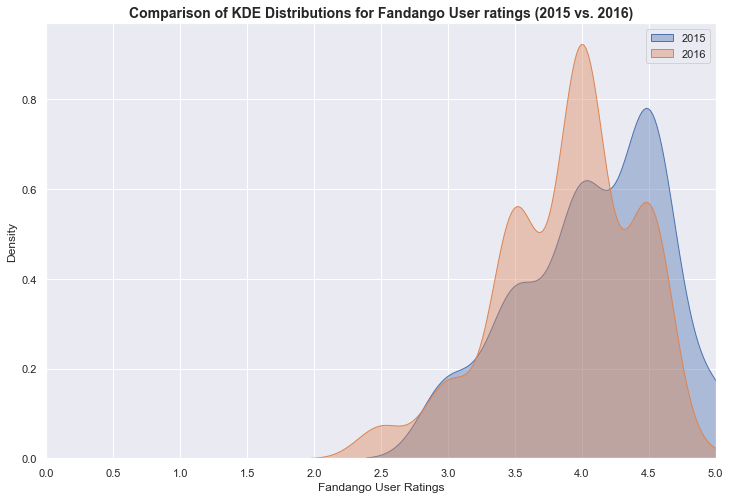

In [300]:
sns.set_theme()
plt.figure(figsize=(12,8))
sns.kdeplot(x = 'Fandango_Stars', data = fandango_2015, fill=True, alpha= 0.4, label='2015')
sns.kdeplot(x = 'fandango', data = fandango_2016, fill=True,  alpha = 0.4, label='2016')

plt.xlim(0,5)
plt.xticks(np.arange(0,5.1,.5))
plt.xlabel('Fandango User Ratings')
plt.title('Comparison of KDE Distributions for Fandango User ratings (2015 vs. 2016)', fontsize=14, fontweight="bold")
plt.legend()
plt.show()

Based on this first inspection it does look like Fandango has altered it's rating system.

The peak of the distribution has been shifted from `4.5` to `4.0` in 2016 and the distribution overall is less left-skewed. There are also a greater density at the lower end (~`2.5`) of the ratings.

## Relative Frequency

We will need to analyze the data more granularly before we can draw any firm conclusions.

We will start by comparing the frequency distributions of the two datasets

In [301]:
display(fandango_2015['Fandango_Stars'].value_counts().sort_index(ascending=False))
display(fandango_2015['Fandango_Stars'].count())
display(fandango_2016['fandango'].value_counts().sort_index(ascending=False))
display(fandango_2016['fandango'].count())

5.0     9
4.5    49
4.0    37
3.5    23
3.0    11
Name: Fandango_Stars, dtype: int64

129

5.0     1
4.5    47
4.0    77
3.5    46
3.0    14
2.5     6
Name: fandango, dtype: int64

191

The samples contain different nr. of movies for the different ratings. Due to this difference we will use relative frequency rather than absolute frequency.

In [302]:
display(fandango_2015['Fandango_Stars'].value_counts(normalize=True).sort_index(ascending=False) * 100)
display(fandango_2016['fandango'].value_counts(normalize=True).sort_index(ascending=False) * 100)

5.0     6.976744
4.5    37.984496
4.0    28.682171
3.5    17.829457
3.0     8.527132
Name: Fandango_Stars, dtype: float64

5.0     0.523560
4.5    24.607330
4.0    40.314136
3.5    24.083770
3.0     7.329843
2.5     3.141361
Name: fandango, dtype: float64

We can see that the percentage of five-star ratings have gone from ~7% in 2015 to around 0.5% in 2016. The percentage of 4.5 ratings have declined and the 4.0 ratings have increased. There is also around 3% 2.5 ratings in 2016 compared to 2015 when there was none.

The direction of change seems to be towards lower scores. The direction is not entirely clear from the relative frequency since the frequency for 4.0 and 3.5 ratings have gone up.

## Direction of Change

We will get more precise details about the direction of the change from 2015 to 2016

In [303]:
print(f"2015 Mean: {fandango_2015['Fandango_Stars'].mean()}")
print(f"2015 Median: {fandango_2015['Fandango_Stars'].median()}")
print(f"2015 Mode: {fandango_2015['Fandango_Stars'].mode()}, \n")

print(f"2016 Mean: {fandango_2016['fandango'].mean()}")
print(f"2016 Median: {fandango_2016['fandango'].median()}")
print(f"2016 Mode: {fandango_2016['fandango'].mode()}")


2015 Mean: 4.0852713178294575
2015 Median: 4.0
2015 Mode: 0    4.5
dtype: float64, 

2016 Mean: 3.887434554973822
2016 Median: 4.0
2016 Mode: 0    4.0
dtype: float64


- The mean value have gone down from 2015 to 2016 but only very slightly.  
- The median, or middle value, have not changed.  
- The mode, or most common values, have gone down from 4.5 to 4.0.

There is a direction of change towards lower scores still, but it is a small one. Let's plot the statistics above to get a better view.

In [304]:
stat_2015 = pd.DataFrame({'mean': fandango_2015['Fandango_Stars'].mean(),
                          'median': fandango_2015['Fandango_Stars'].median(),
                          'mode' : fandango_2015['Fandango_Stars'].mode()
                         }
                        )
stat_2016 = pd.DataFrame({'mean': fandango_2016['fandango'].mean(),
                          'median': fandango_2016['fandango'].median(),
                          'mode' : fandango_2016['fandango'].mode()
                         }
                        )
stats = pd.concat([stat_2015, stat_2016])
stats.index = ['2015', '2016']
stats = stats.T
stats

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


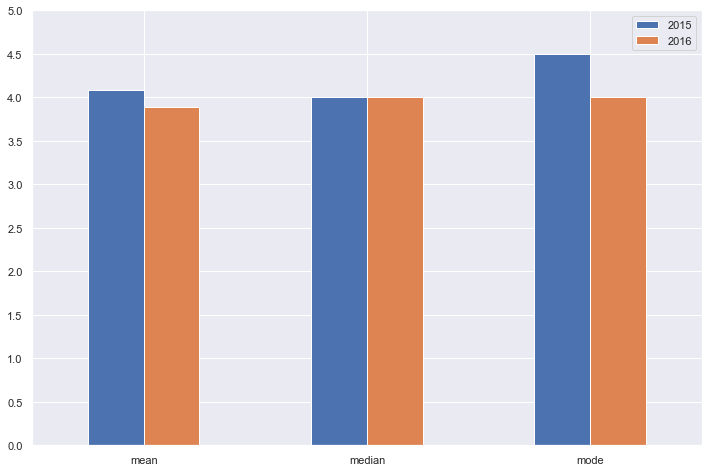

In [305]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

stats.plot.bar(rot = 0, ax=ax)

plt.ylim(0,5)
plt.yticks(np.arange(0,5.1,.5))

plt.show()

Again we can see a small lowering of the mean going from 2015 to 2016. The change in mode is also clear. Overall, there is a small change towards lower scores.

# IV. Conclusion

Based on our analysis we can conclude that there was a slight change towards lower scores on Fandango's website, going from 2015 to 2016. 

Most likely the change was caused by Fandango correcting their rating system to round user scores appropriately.